In [1]:
#importing necessary libraries 
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import yfinance as yf
from urllib.parse import quote
import seaborn as sns #library not from class
%matplotlib inline
from scipy.optimize import minimize
import mplcursors

In [2]:
#Load .env environment variables
from dotenv import load_dotenv
load_dotenv()


True

In [3]:
# Set a random seed for reproducibility
np.random.seed(42)

In [4]:
# Set Alpaca API key and secret
APCA_API_KEY_ID = os.getenv("APCA_API_KEY")
APCA_API_SECRET_KEY = os.getenv("APCA_SECRET_KEY")
ALPACA_ENDPOINT_KEY = os.getenv("ALPACA_END_POINT")

#ensuring api keys are correct 
#print(os.getenv("APCA_API_KEY_ID"))
#print(os.getenv("APCA_API_SECRET_KEY"))
#print(os.getenv("ALPACA_ENDPOINT_KEY"))

# Create the Alpaca API object
alpaca = tradeapi.REST(APCA_API_KEY_ID, APCA_API_SECRET_KEY, api_version="v2",base_url= ALPACA_ENDPOINT_KEY)

## Part 1 - Portfolio Optimization 


In [5]:
#initializing variables
initial_investment = 1000
print(f'The initial investment is: ${initial_investment}')

stock_tickers = ['AAPL', 'AMZN', 'MSFT'] 
ticker_string = ', '.join(stock_tickers)
print(f'The selected stocks are: {stock_tickers}')

start_date = '2020-11-08'  # Set your desired start date
print(f'The start date is: {start_date}')

end_date = '2022-11-08'  # Set your desired start date
print(f'The start date is: {start_date}')

num_sims = 500 
print(f'The number of monte carlo simulations is: {num_sims}')

num_years = 2

The initial investment is: $1000
The selected stocks are: ['AAPL', 'AMZN', 'MSFT']
The start date is: 2020-11-08
The start date is: 2020-11-08
The number of monte carlo simulations is: 500


### Import S&P500 Data From Alpacas and Display Closing Prices From Chosen Stocks

In [6]:
from urllib.parse import quote

# Importing SP500 
spy = ["SPY"]

# Define the list of stock tickers, excluding SP500 initially
tickersList = stock_tickers + ['SPY']

# Set timeframe to '1D'
timeframe = '1D'

# Convert start_date and end_date to ISO format with New York timezone
start_date = pd.Timestamp(start_date, tz='America/New_York').isoformat()
end_date = pd.Timestamp(end_date, tz='America/New_York').isoformat()

# Create an empty DataFrame to store the results for tickers
df_combined_tickers = pd.DataFrame()

# Make the request to Alpaca API for each ticker
for ticker in tickersList:
    # Convert the ticker to URL-encoded format
    ticker_encoded = quote(ticker)
    
    # Make the request to Alpaca API to get bars data
    df_ticker = alpaca.get_bars(ticker_encoded, timeframe, limit=None, start=start_date, end=end_date).df
    
    # Select only the 'close' column and assign the new column name with the ticker symbol for clarity purposes
    df_ticker = df_ticker['close'].rename(ticker)
    
    # Combine the results
    df_combined_tickers = pd.concat([df_combined_tickers, df_ticker], axis=1)
    
spyDF = df_combined_tickers['SPY']
df_combined_tickers.drop(columns='SPY',inplace=True)

# Display the results (closing prices for chosen tickers)
df_combined_tickers

,AAPL,AMZN,MSFT
2020-11-09 05:00:00+00:00,116.32,3143.74,218.39
2020-11-10 05:00:00+00:00,116.00,3035.02,211.01
2020-11-11 05:00:00+00:00,119.49,3137.39,216.55
2020-11-12 05:00:00+00:00,119.21,3110.28,215.44
2020-11-13 05:00:00+00:00,119.26,3128.81,216.51
...,...,...,...
2022-11-02 04:00:00+00:00,145.03,92.12,220.10
2022-11-03 04:00:00+00:00,138.88,89.30,214.25
2022-11-04 04:00:00+00:00,138.38,90.98,221.39
2022-11-07 05:00:00+00:00,138.92,90.53,227.87


### Calculate Daily Return, Mean, Standard Deviation, and Last Day Closing Prices for selected tickers and SP500

In [7]:
# Calculate daily returns for all ticker's closing prices
daily_returns_tickers = df_combined_tickers.pct_change()
daily_returns_tickers.dropna(inplace=True)

# Display daily returns for the tickers
print("\nDaily Returns for Chosen Stocks:")
print(daily_returns_tickers)

mean = {} 

# Iterate through each stock in the list of tickers
for stock in stock_tickers:
    # Check if the stock exists in the daily returns columns
    if stock in daily_returns_tickers.columns:
        mean[stock] = daily_returns_tickers.mean()[stock]  # Calculate mean for the stock and store in the dictionary
        print(f'{stock} mean: {mean[stock]}')  # Print the mean of daily returns for the stock


Daily Returns for Chosen Stocks:
                               AAPL      AMZN      MSFT
2020-11-10 05:00:00+00:00 -0.002751 -0.034583 -0.033793
2020-11-11 05:00:00+00:00  0.030086  0.033730  0.026255
2020-11-12 05:00:00+00:00 -0.002343 -0.008641 -0.005126
2020-11-13 05:00:00+00:00  0.000419  0.005958  0.004967
2020-11-16 05:00:00+00:00  0.008720  0.000719  0.003325
...                             ...       ...       ...
2022-11-02 04:00:00+00:00 -0.037305 -0.048249 -0.035368
2022-11-03 04:00:00+00:00 -0.042405 -0.030612 -0.026579
2022-11-04 04:00:00+00:00 -0.003600  0.018813  0.033326
2022-11-07 05:00:00+00:00  0.003902 -0.004946  0.029270
2022-11-08 05:00:00+00:00  0.004175 -0.006075  0.004388

[503 rows x 3 columns]
AAPL mean: 0.0005381646729787423
AMZN mean: -0.0027533898608570985
MSFT mean: 0.0002488019621129521


In [8]:
# Calculate and display daily returns for 'SPY'
daily_returns_spy = spyDF.pct_change()
daily_returns_spy.dropna(inplace=True)

# Display daily returns for 'SPY'
print("\nDaily Returns for SPY:")
print(daily_returns_spy)

# Calculate and display mean of daily return for 'SPY'
mean_spy = daily_returns_spy.mean()
print("\nSPY mean:")
print(mean_spy)


Daily Returns for SPY:
2020-11-10 05:00:00+00:00   -0.001523
2020-11-11 05:00:00+00:00    0.007456
2020-11-12 05:00:00+00:00   -0.009475
2020-11-13 05:00:00+00:00    0.013471
2020-11-16 05:00:00+00:00    0.012510
                               ...   
2022-11-02 04:00:00+00:00   -0.025096
2022-11-03 04:00:00+00:00   -0.010297
2022-11-04 04:00:00+00:00    0.014393
2022-11-07 05:00:00+00:00    0.009566
2022-11-08 05:00:00+00:00    0.005395
Name: SPY, Length: 503, dtype: float64

SPY mean:
0.00021710035251848437


In [9]:
# Calculate and display standard deviation for each ticker
std_devs = {}
for stock in stock_tickers:
    if stock in daily_returns_tickers.columns:
        std_devs[stock] = daily_returns_tickers.std()[stock]
        print(f'{stock} standard deviation: {std_devs[stock]}')

AAPL standard deviation: 0.0188248121756779
AMZN standard deviation: 0.04844792840659369
MSFT standard deviation: 0.01763179130248356


In [10]:
# Calculate and display standard deviation for 'SPY'
std_dev_spy = daily_returns_spy.std()
print("\nStandard Deviation for SPY:")
print(std_dev_spy)


Standard Deviation for SPY:
0.011762364889972853


In [11]:
# Get the last day's closing prices for each ticker
last_day_closing_prices = df_combined_tickers.iloc[-1]

# Display the last day's closing prices
print("\nLast Day's Closing Prices:")
print(last_day_closing_prices)



Last Day's Closing Prices:
AAPL    139.50
AMZN     89.98
MSFT    228.87
Name: 2022-11-08 05:00:00+00:00, dtype: float64


In [12]:
# Get the last day's closing price for 'SPY'
spy_last_day_closing_price = spyDF.iloc[-1]
print("\nLast Day's Closing Price for SPY:")
print(spy_last_day_closing_price)


Last Day's Closing Price for SPY:
382.0


## Part 2 - Monte Carlo Simulations

In [13]:
# Calculate the total number of simulations based on the specified number of years and trading days per year
num_sims = (num_years * 252)

# Initialize DataFrames to store Monte Carlo simulation results
monte_carlo_results = pd.DataFrame()
monte_carlo_spy_results = pd.DataFrame()

# Create lists and variables to store optimization results and simulated data
optimal_weights_list = []
simulated_returns_list = []

# Create dictionaries and DataFrames to store simulated prices for individual stocks and SPY
simulated_prices_stocks = {stock: pd.DataFrame() for stock in stock_tickers}
simulated_prices_spy = pd.DataFrame()

# Define the negative Sharpe ratio function for optimization
def negative_sharpe_ratio(weights):
    weights_array = np.array(weights)
    portfolio_returns = np.sum(simulated_returns.mean() * weights_array) * 252
    portfolio_volatility = np.sqrt(np.dot(weights_array.T, np.dot(simulated_returns.cov() * 252, weights_array)))
    sharpe_ratio = portfolio_returns / portfolio_volatility
    return -sharpe_ratio

# Define the constraint function ensuring allocation sums to 1
def check_allocation_sum(weights):
    return np.sum(weights) - 1

simulated_prices_spy_list = [spy_last_day_closing_price] + [0] * (num_sims - 1)

# Monte Carlo simulation loop
for simulation_index in range(num_sims):
    # Simulate prices for each trading day
    simulated_prices_dict = {
        stock: [last_day_closing_prices[stock]] + [0] * (num_sims - 1) for stock in stock_tickers
        }
    
    for day_index in range(1, num_sims):
        for stock in stock_tickers:
        # Simulate stock prices using a normal distribution based on historical mean and standard deviation
            simulated_price = simulated_prices_dict[stock][day_index - 1] * (
                1 + np.random.normal(mean[stock], std_devs[stock])
            )
            simulated_prices_dict[stock][day_index] = simulated_price

        # Simulate SPY prices using a normal distribution based on historical mean and standard deviation
        simulated_spy_price = simulated_prices_spy_list[day_index - 1] * (
            1 + np.random.normal(mean_spy, std_dev_spy)
        )
        simulated_prices_spy_list[day_index] = simulated_spy_price

    # Store simulated prices in DataFrames
    for stock in stock_tickers:
        simulated_prices_stocks[stock][simulation_index] = pd.Series(simulated_prices_dict[stock])

    simulated_prices_df = pd.DataFrame(simulated_prices_dict)
    simulated_returns = simulated_prices_df.pct_change().dropna()
    simulated_returns_list.append(simulated_returns)

    # Define optimization constraints and boundaries
    constraints = [{'type': 'eq', 'fun': check_allocation_sum}]
    allocation_bounds = [(0, 1)] * len(stock_tickers)

    # Perform portfolio optimization using the scipy minimize function
    initial_guess = [1 / len(stock_tickers)] * len(stock_tickers)
    optimization_results = minimize(negative_sharpe_ratio, initial_guess, method='SLSQP', bounds=allocation_bounds, constraints=constraints)

    # Retrieve and store optimal weights
    optimal_weights = optimization_results.x
    optimal_weights_list.append(optimal_weights)

    # Calculate portfolio daily returns using the optimized weights
    portfolio_daily_returns = simulated_returns.dot(optimal_weights)

    # Calculate cumulative returns for the portfolio
    monte_carlo_results[simulation_index] = (1 + portfolio_daily_returns).cumprod()

    # Calculate cumulative returns for the SPY simulation
    monte_carlo_spy_results[simulation_index] = (1 + pd.Series(simulated_prices_spy_list).pct_change().dropna()).cumprod()

    print(optimal_weights)


[0.52367221 0.03735402 0.43897377]
[1.00000000e+00 1.66533454e-16 5.55111512e-17]
[1. 0. 0.]
[0.61557773 0.         0.38442227]
[5.00063532e-13 0.00000000e+00 1.00000000e+00]
[1. 0. 0.]
[0.64916733 0.00910763 0.34172504]
[0.66679528 0.         0.33320472]
[1.00000000e+00 8.32667268e-16 0.00000000e+00]
[1.00000000e+00 2.77555756e-16 0.00000000e+00]
[2.20194536e-01 1.73922291e-15 7.79805464e-01]
[1. 0. 0.]
[0.00000000e+00 2.77555756e-16 1.00000000e+00]
[6.51712954e-01 1.04442754e-11 3.48287046e-01]
[1.00000000e+00 0.00000000e+00 1.66533454e-16]
[1.68004499e-13 4.85757268e-13 1.00000000e+00]
[0.07939972 0.         0.92060028]
[0.00000000e+00 1.00000000e+00 5.20417043e-17]
[2.24037366e-16 1.00000000e+00 5.55111512e-17]
[0.53181136 0.00828778 0.45990086]
[4.29597199e-01 1.90880068e-15 5.70402801e-01]
[0.29029243 0.         0.70970757]
[0.06895073 0.         0.93104927]
[1.00000000e+00 0.00000000e+00 8.53844773e-12]
[0.48031839 0.         0.51968161]
[1.00000000e+00 0.00000000e+00 1.03250741

/var/folders/bk/8p802pg50f31n1clyfc4y7700000gn/T/ipykernel_45750/1332557318.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  simulated_prices_stocks[stock][simulation_index] = pd.Series(simulated_prices_dict[stock])
/var/folders/bk/8p802pg50f31n1clyfc4y7700000gn/T/ipykernel_45750/1332557318.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  monte_carlo_results[simulation_index] = (1 + portfolio_daily_returns).cumprod()
/var/folders/bk/8p802pg50f31n1clyfc4y7700000gn/T/ipykernel_45750/1332557318.py:78: PerformanceWarning: 

[1.00000000e+00 1.66533454e-16 5.55111512e-17]
[0.56167243 0.         0.43832757]
[1.00000000e+00 5.12506704e-14 0.00000000e+00]
[0.00000000e+00 1.83186799e-15 1.00000000e+00]
[1.0000000e+00 0.0000000e+00 5.8272831e-14]
[1.80133686e-13 0.00000000e+00 1.00000000e+00]
[1.00000000e+00 9.67351199e-14 0.00000000e+00]
[0.81857289 0.1699858  0.01144131]
[1.00000000e+00 1.04923015e-13 0.00000000e+00]
[0.91763621 0.         0.08236379]
[0.66508388 0.         0.33491612]
[5.55106115e-01 4.44893885e-01 2.04697370e-16]
[1.00000000e+00 0.00000000e+00 7.38131778e-13]
[7.83740048e-01 7.95035466e-17 2.16259952e-01]
[7.23219883e-01 2.78669075e-12 2.76780117e-01]
[0.8068291 0.1931709 0.       ]
[6.25269465e-01 5.95226993e-17 3.74730535e-01]
[3.37347864e-01 8.85988592e-12 6.62652136e-01]
[5.96317780e-01 1.89366502e-12 4.03682220e-01]
[4.69289055e-01 5.54363575e-13 5.30710945e-01]
[0.75110268 0.         0.24889732]
[1.00000000e+00 1.64895875e-13 1.61842761e-13]
[5.40749741e-01 4.49265408e-13 4.59250259e-0

###  Representing the Simulated Cumulative Returns of a portfolio over time for 500 Monte Carlo Simulations

Each column corresponds to a specific simulation, and each row represents the cumulative returns at a specific time point

In [14]:
monte_carlo_results

,0,1,2,3,4,5,6,7,8,9,...,494,495,496,497,498,499,500,501,502,503
1,1.009948,0.986059,0.987763,1.015982,0.981199,1.003170,0.997045,1.001117,1.001119,0.995340,...,1.007933,0.999967,1.009391,0.997355,1.007248,1.001392,1.011488,0.997885,0.993970,1.012301
2,1.019824,0.981680,1.018018,1.042812,0.972136,0.977939,1.007584,0.993074,0.995575,1.002632,...,1.005490,0.976673,1.014536,1.003135,0.973025,1.019357,1.010673,0.988171,0.987891,0.992881
3,1.012742,0.983316,0.996505,1.044595,0.975515,0.982436,1.018639,0.974343,1.017081,0.966064,...,1.000788,0.959843,1.019914,1.006683,0.994465,1.016838,1.045093,0.985539,0.978709,0.988403
4,0.998422,0.927952,1.006739,1.038511,0.949905,1.001234,1.014589,0.982724,1.006324,0.979121,...,0.983208,0.950972,1.032295,0.984916,0.987411,1.008397,1.039827,0.967178,0.952076,1.001213
5,0.982291,0.932113,1.011162,1.036986,0.969644,0.989393,1.033020,0.962302,1.029686,1.011160,...,0.968962,0.943676,1.064701,0.975553,0.983447,1.002422,1.064373,0.960001,0.945696,0.976223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,1.580763,1.622450,1.541140,1.318633,1.081029,1.832752,1.843367,1.182952,2.400217,1.724540,...,1.352117,1.723348,0.703381,1.926502,1.900166,2.942037,2.253088,1.650805,1.691245,0.847759
500,1.576287,1.608410,1.549206,1.337843,1.089891,1.786442,1.819846,1.183065,2.379513,1.707736,...,1.373687,1.720061,0.718825,1.857026,1.900736,2.955652,2.273440,1.659153,1.774702,0.880950
501,1.556170,1.579452,1.540773,1.313578,1.056112,1.768000,1.824485,1.172250,2.406448,1.748890,...,1.383764,1.715579,0.755839,1.844382,1.892699,2.921965,2.275482,1.690768,1.794782,0.892801
502,1.528184,1.566005,1.484592,1.298220,1.035808,1.791364,1.809874,1.148754,2.366677,1.734772,...,1.370775,1.740766,0.770543,1.867264,1.888483,2.972191,2.258918,1.710672,1.796801,0.915915


In [15]:
#commenting out because the output is long (500 sims)
#mc_opt_weights

In [16]:
# Initialize lists to store individual DataFrames
monte_carlo_avg_optimized_list = []
mc_uniform_portfolio_daily_returns_list = []

# Monte Carlo Simulation Loop
for simulation_index in range(num_sims):
    # Simulate prices for each trading day
    simulated_prices_dict = {
        stock: [last_day_closing_prices[stock]] * num_sims for stock in stock_tickers
    }
    simulated_prices_spy_list = [spy_last_day_closing_price] * num_sims

    for day_index in range(1, num_sims):
        for stock in stock_tickers:
            # Simulate stock prices using a normal distribution based on historical mean and standard deviation
            simulated_price = simulated_prices_dict[stock][day_index - 1] * (
                1 + np.random.normal(mean[stock], std_devs[stock])
            )
            simulated_prices_dict[stock][day_index] = simulated_price

        # Simulate SPY prices using a normal distribution based on historical mean and standard deviation
        simulated_spy_price = simulated_prices_spy_list[day_index - 1] * (
            1 + np.random.normal(mean_spy, std_dev_spy)
        )
        simulated_prices_spy_list[day_index] = simulated_spy_price

    # Store simulated prices in DataFrames
    simulated_prices_df = pd.DataFrame(simulated_prices_dict)
    simulated_returns = simulated_prices_df.pct_change().dropna()

    # ... (rest of the code)

    # Append DataFrames to the lists
    monte_carlo_avg_optimized_list.append(monte_carlo_results)
    mc_uniform_portfolio_daily_returns_list.append(monte_carlo_spy_results)

# Concatenate DataFrames to create the final result
monte_carlo_avg_optimized = pd.concat(monte_carlo_avg_optimized_list, axis=1)
mc_uniform_portfolio_daily_returns = pd.concat(mc_uniform_portfolio_daily_returns_list, axis=1)


### Displaying the Average Weights and Standard Deviation of the Optimized Weights for each stock in the portfolio

In [17]:
# Calculate average weights and standard deviation
average_weights_optimized = np.mean(optimal_weights_list, axis=0)
std_dev_weights_optimized = np.std(optimal_weights_list, axis=0)

# Display results
for i in range(len(stock_tickers)):
    print(f"{stock_tickers[i]}: Average Weight = {average_weights_optimized[i]}, Standard Deviation = {std_dev_weights_optimized[i]}")


AAPL: Average Weight = 0.5229387517898653, Standard Deviation = 0.4025040715024445
AMZN: Average Weight = 0.05701820208001373, Standard Deviation = 0.22126335754625812
MSFT: Average Weight = 0.42004304612959525, Standard Deviation = 0.3960284722354827


In [18]:
monte_carlo_avg_optimized.dropna(inplace=True)
monte_carlo_avg_optimized

,0,1,2,3,4,5,6,7,8,9,...,494,495,496,497,498,499,500,501,502,503
1,1.009948,0.986059,0.987763,1.015982,0.981199,1.003170,0.997045,1.001117,1.001119,0.995340,...,1.007933,0.999967,1.009391,0.997355,1.007248,1.001392,1.011488,0.997885,0.993970,1.012301
2,1.019824,0.981680,1.018018,1.042812,0.972136,0.977939,1.007584,0.993074,0.995575,1.002632,...,1.005490,0.976673,1.014536,1.003135,0.973025,1.019357,1.010673,0.988171,0.987891,0.992881
3,1.012742,0.983316,0.996505,1.044595,0.975515,0.982436,1.018639,0.974343,1.017081,0.966064,...,1.000788,0.959843,1.019914,1.006683,0.994465,1.016838,1.045093,0.985539,0.978709,0.988403
4,0.998422,0.927952,1.006739,1.038511,0.949905,1.001234,1.014589,0.982724,1.006324,0.979121,...,0.983208,0.950972,1.032295,0.984916,0.987411,1.008397,1.039827,0.967178,0.952076,1.001213
5,0.982291,0.932113,1.011162,1.036986,0.969644,0.989393,1.033020,0.962302,1.029686,1.011160,...,0.968962,0.943676,1.064701,0.975553,0.983447,1.002422,1.064373,0.960001,0.945696,0.976223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,1.580763,1.622450,1.541140,1.318633,1.081029,1.832752,1.843367,1.182952,2.400217,1.724540,...,1.352117,1.723348,0.703381,1.926502,1.900166,2.942037,2.253088,1.650805,1.691245,0.847759
500,1.576287,1.608410,1.549206,1.337843,1.089891,1.786442,1.819846,1.183065,2.379513,1.707736,...,1.373687,1.720061,0.718825,1.857026,1.900736,2.955652,2.273440,1.659153,1.774702,0.880950
501,1.556170,1.579452,1.540773,1.313578,1.056112,1.768000,1.824485,1.172250,2.406448,1.748890,...,1.383764,1.715579,0.755839,1.844382,1.892699,2.921965,2.275482,1.690768,1.794782,0.892801
502,1.528184,1.566005,1.484592,1.298220,1.035808,1.791364,1.809874,1.148754,2.366677,1.734772,...,1.370775,1.740766,0.770543,1.867264,1.888483,2.972191,2.258918,1.710672,1.796801,0.915915


### Bar Chart of Average Weights of Chosen Stocks

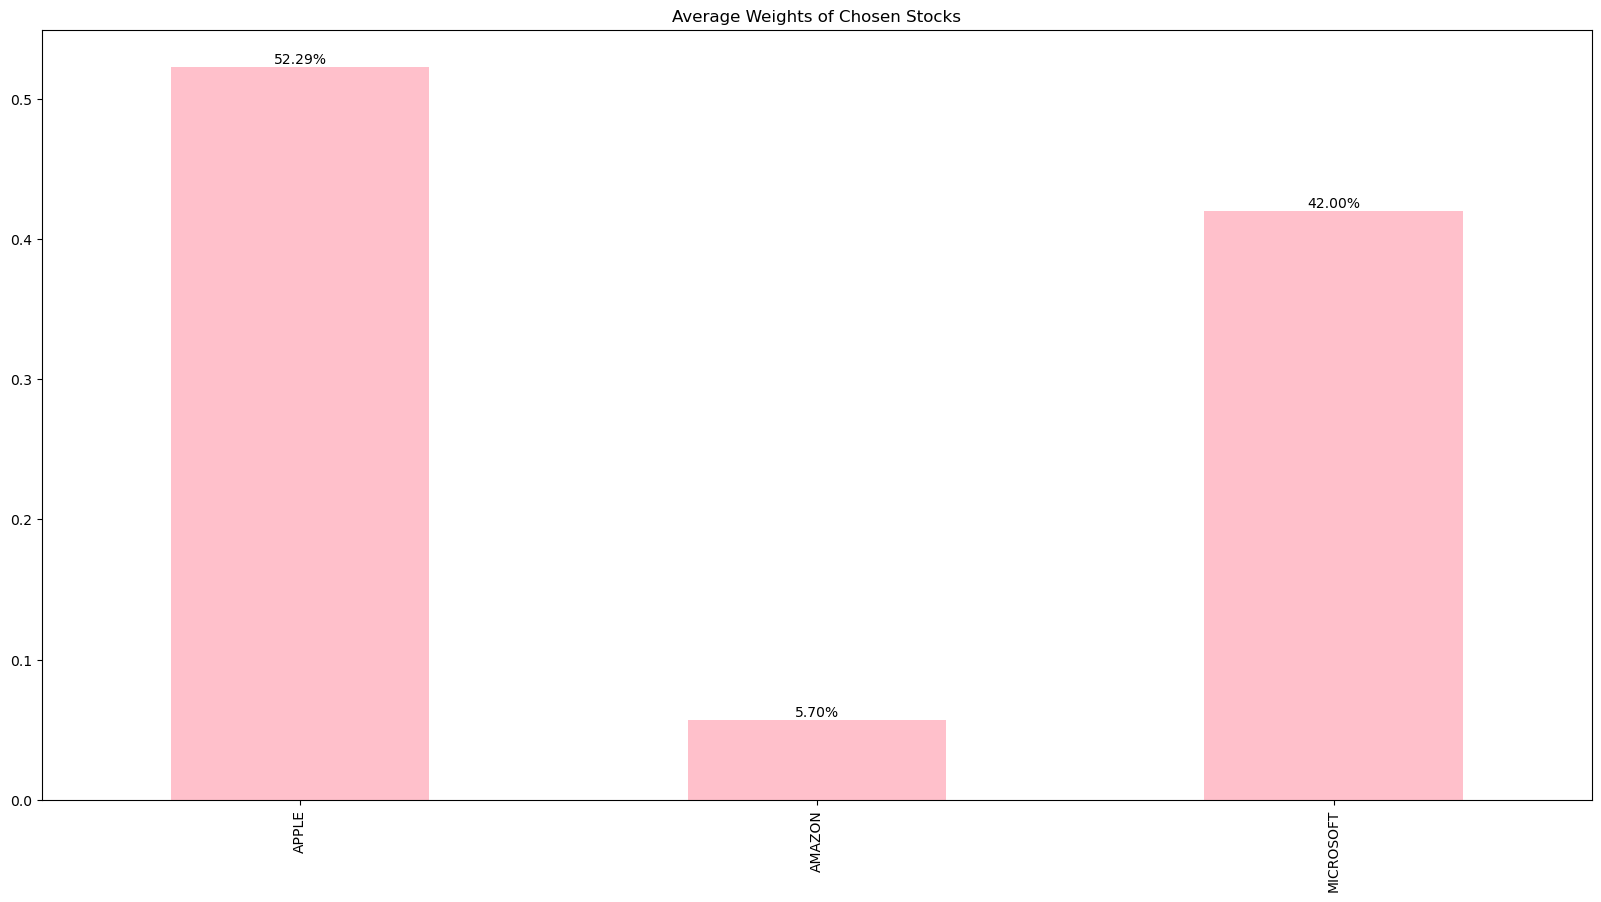

In [19]:
# Plotting the average weights
average_weights_series = pd.Series(average_weights_optimized, index=stock_tickers)
ax = average_weights_series.plot.bar(figsize=(20, 10), color='pink', title='Average Weights of Chosen Stocks')

# Adding hover information to the plot
for i, val in enumerate(average_weights_optimized):
    plt.text(i, val, f'{val:.2%}', ha='center', va='bottom')

# Adding custom tick labels
plt.xticks(range(len(stock_tickers)), ['APPLE', 'AMAZON', 'MICROSOFT'])

# Adding exact weight information using mplcursors
cursor = mplcursors.cursor(ax, hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(f"Weight: {sel.artist.get_height():.2%}"))

# Show the plot
plt.show()

In [20]:
monte_carlo_avg_optimized.iloc[-1]

0      1.522135
1      1.630817
2      1.499434
3      1.307577
4      1.044797
         ...   
499    2.926063
500    2.171344
501    1.729585
502    1.784305
503    0.896755
Name: 503, Length: 254016, dtype: float64

In [ ]:
# plot both average weights and optimal weights of all portfolios
averageWeightPlot = monte_carlo_avg_optimized.plot(legend=None, style='--', title=f'{num_sims} Monte Carlo Simulations', figsize=(100,50))
monte_carlo_results.plot(legend=None, title=f'{num_sims} Monte Carlo Simulations', figsize=(20,10),ax=ax)

<Axes: title={'center': '504 Monte Carlo Simulations'}>

In [ ]:
# plot average weights

monte_carlo_avg_opt.plot(legend=None, style='--', title=f'{number_simulations} Monte Carlo Simulations', figsize=(20,10))